# **Eurozone Macro Dataset: Mapping the Data to the Model**
### _Data Collection, and Processing for Estimation._

In [1]:
from ECB_functions import (build_ecb_dataset, 
                           per_capita, 
                           rebase_index,
                           interpolation,
                           real_growth_rates,
                           build_estimation_df,
                           seasonally_adjustment,
                           plot,
                           save_df)

## **1. Raw Data Sources and ECB Series Codes**

All macroeconomic series used in this project are collected from the [ECB Data Portal](https://data.ecb.europa.eu). The table below lists the raw series, their economic interpretation, and their corresponding ECB identification codes. These series form the foundation for the construction of the macro dataset used in the model estimation.

| Description                               | Notation     | ECB Code                                                                 |
|-------------------------------------------|------------------------|--------------------------------------------------------------------------|
| Nominal GDP (millions of €)              | $ Y_t $              | *MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N*                            |
| GDP Deflator Index                       | $ P_t $              | *MNA.Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.IX.D.N*                             |
| Total Population (thousands)             | $ Pop_t $              | *ENA.A.N.I9.W0.S1.S1._Z.POP._Z._Z._Z.PS._Z.N*                            |
| Private Consumption (millions of €)      | $ C_t $              | *MNA.Q.Y.I9.W0.S1M.S1.D.P31._Z._Z._T.EUR.V.N*                            |
| Total Investment (millions of €)         | $ I_t $ | *MNA.Q.Y.I9.W0.S1.S1.D.P51G.N11G._T._Z.EUR.V.N*                          |
| Public Consumption (millions of €)       | $ G_t $            | *MNA.Q.Y.I9.W0.S13.S1.D.P3._Z._Z._T.EUR.V.N*                             |
| Social Benefits (millions of €)          | $ T_t^{\text{cash}} $ | *QSA.Q.Y.I9.W0.S1M.S1.N.B.D62._Z._Z._Z.XDC._T.S.V.N._T*                  |
| Social Transfers in Kind (millions of €) | $ T_t^{\text{in-kind}} $ | *QSA.Q.Y.I9.W0.S1M.S1.N.B.D63._Z._Z._Z.XDC._T.S.V.N._T*              |
| Debt-to-GDP Ratio (%)                    | $ S_{B,t} $  | *GFS.Q.N.I9.W0.S13.S1.C.L.LE.GD.T._Z.XDC_R_B1GQ_CY._T.F.V.N._T*          |
| Unemployment Rate (%)                    | $ U_t $              | *LFSI.M.I9.S.UNEHRT.TOTAL0.15_74.T*                                     |
| Compensation per Employee (Index)        | $ W_t $              | *MNA.Q.Y.I9.W2.S1.S1._Z.COM_PS._Z._T._Z.IX.V.N*                          |
| Euribor 3-Months (%)                     | $ R_{S,t} $              | *FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA*                                    |

The 11 ECB time series are fetched and merged into a quarterly DataFrame by the **_build_ecb_dataset()_** function. Monthly series are converted to quarterly frequency by averaging over each calendar quarter. All series are seasonally adjusted as provided by the ECB, except for the debt-to-GDP ratio, which will be corrected later.

All functions and packages used to construct the dataset are documented in the **_ECB_functions.py_** file.


In [2]:
ECB_data = build_ecb_dataset()

## **2. Data Processing**
### **2.1. Index Normalization**

Before proceeding with transformations, it is good practice to normalize all index-based series to a common reference date. In this case, both the GDP deflator index $ P_t $ and the nominal compensation per employee index $ W_t $ are re-based to March 2015 (i.e. the quarter ending 2015-Q1).

In [3]:
ECB_data = rebase_index(ECB_data, date_col="TIME_PERIOD", new_base_date="2015-03")

### **2.2. Building Aggregates**
**_Public Transfers_.**

To match the government transfers component $ T_t $ in the model, we construct a new variable by summing two national accounts items: social benefits perceived in cash $ T_t^{\text{cash}} $ and social transfers in kind $ T_t^{\text{in-kind}} $. This composite measure captures both cash transfers and in-kind public support to households as follows,

$$ T_t = T_t^{\text{cash}} + T_t^{\text{in-kind}} .$$

In [4]:
ECB_data['Government Transfers (millions of €)'] = (ECB_data['Social Benefits (millions of €)'] 
                                                  + ECB_data['Social Transfers in Kind (millions of €)'])

**_Quarterly Total Population_.**

The population series $ Pop_t $ is available only at an annual frequency. To fill in the missing quarterly observations, a simple linear interpolation is applied. Given the slow-moving nature of population growth in the euro area, this approximation introduces negligible bias and preserves the overall quarterly structure of the dataset.

In [5]:
ECB_data = interpolation(ECB_data)

Once these adjustments are complete and the raw macroeconomic dataset is fully constructed, the remaining rows with missing values are removed. This ensures a clean, balanced panel suitable for estimation over the sample period.

In [6]:
ECB_data = ECB_data.dropna()

**_Computing Per-Capita Variables_**

All endogenous variables in the model are expressed in **per-capita** terms. Therefore, all nominal variables expressed in levels (e.g., GDP, consumption, investment, public consumption, transfers) are divided by the total population series to obtain their per-capita counterparts.

In [7]:
ECB_data = per_capita(ECB_data)

### **2.3. Real Variables and Log-Differencing**
**_Real Variables_.**

The first step is to express the variables in real terms by deflating them using the GDP deflator index $P_t$. The resulting real, per capita level variable is given by,
$$
\bar{X}_t = \frac{X_t}{P_t}.
$$

**_First-Difference Filter_.**

A first-order log-difference filter is then applied to obtain growth rates,
$$
dx_t = x_t - x_{t-1}
$$
where $ x_t $ is the logarithm of the real, per capita variable $ \bar{X}_t $. This transformation is applied to GDP, consumption, investment, public consumption, transfers, and wages using the **_real_growth_rates()_** function. Note that the inflation rate $\pi_t$, is computed as the quarterly growth rate of the GDP deflator, $ P_t $. 

Variables that are already stationary, or that enter the model in levels, do not require any transformation. This applies to the unemployment rate, the 3-month Euribor, and the debt-to-GDP ratio.

In [8]:
ECB_data = real_growth_rates(ECB_data)

## **3. Building the Final Dataset**

The final dataset consists of 10 macroeconomic variables:

- Real per capita GDP growth — $dy^{obs}_t$
- Real per capita private consumption growth — $dc^{obs}_t$
- Real per capita investment growth — $di^{obs}_t$
- Real per capita public consumption growth — $dg^{obs}_t$
- Real per capita public transfers growth — $d\tau^{obs}_t$
- Real wage growth — $\pi^{obs}_{w,t}$
- Inflation — $\pi^{obs}_t$
- Unemployment rate — $u^{obs}_t$
- Government debt-to-GDP ratio — $s^{obs}_{B,t}$
- 3-month Euribor — $r^{obs}_{S,t}$

The dataset is restricted to the pre-pandemic period, covering the span from 2000Q2 to 2019Q4, for a total of 79 quarters. The post-COVID period is deliberately excluded to avoid the need to model the zero lower bound on nominal interest rates, which would introduce non-linearities into the model and significantly increase the complexity of the estimation process.

In [10]:
estimation_df = build_estimation_df(ECB_data)
estimation_df = estimation_df[estimation_df['t'] <= '2019-12-31']

**_Visual Inspection_.**

The following plots display the time series of each variable in the final estimation dataset over the sample period 2000-Q2 to 2019-Q4.

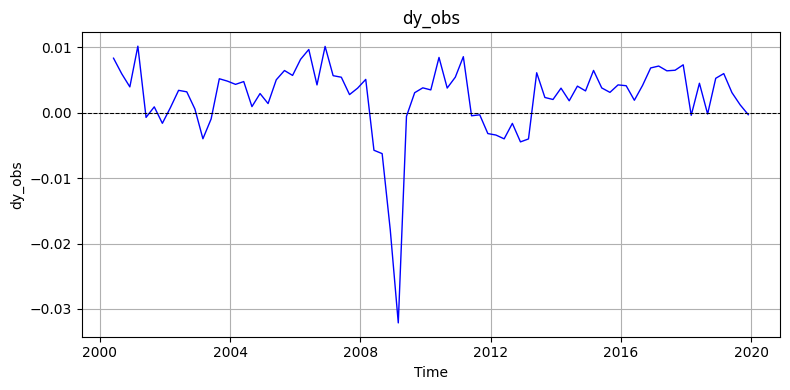

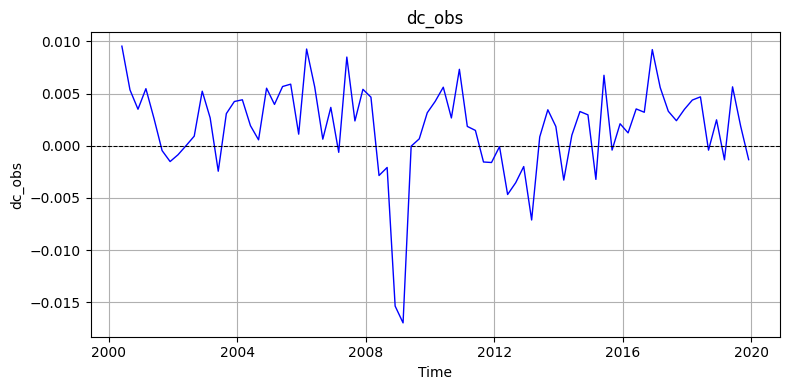

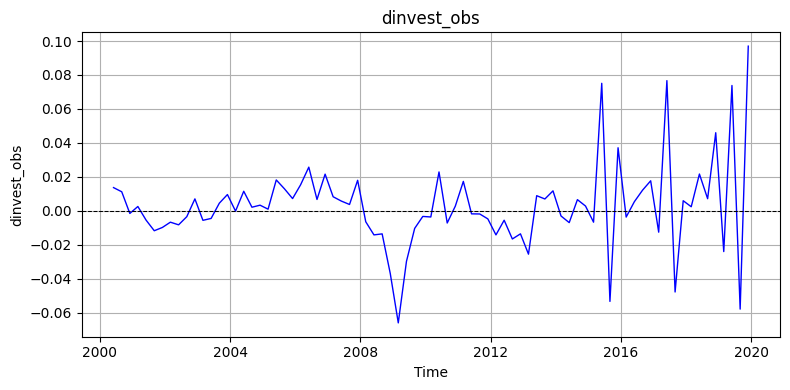

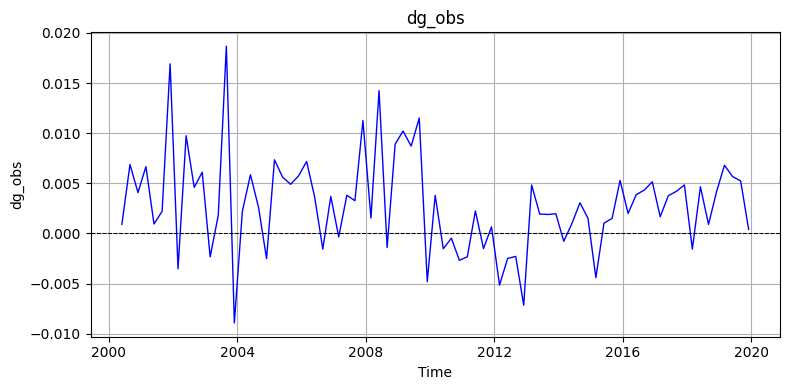

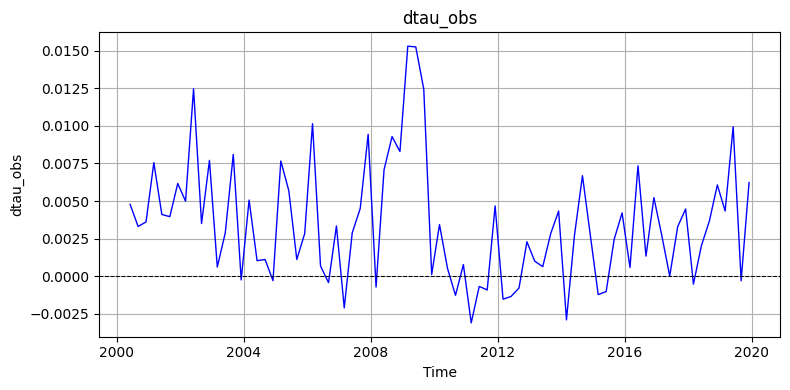

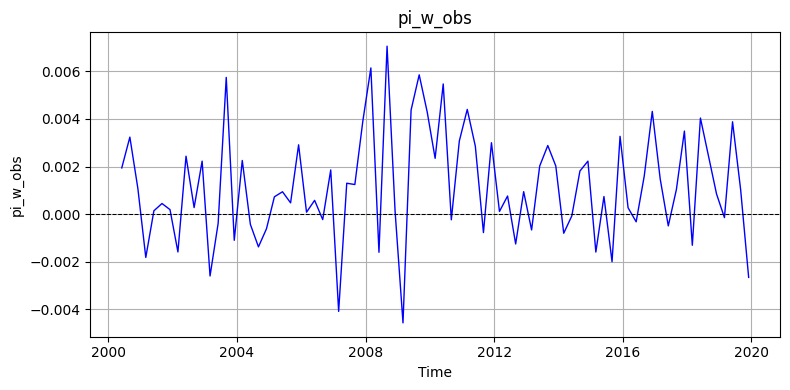

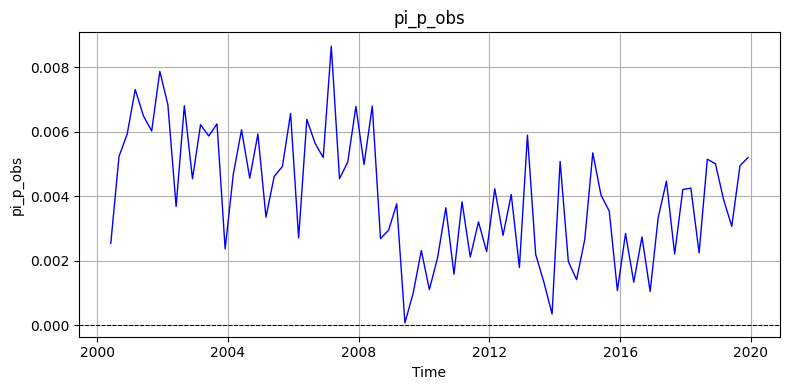

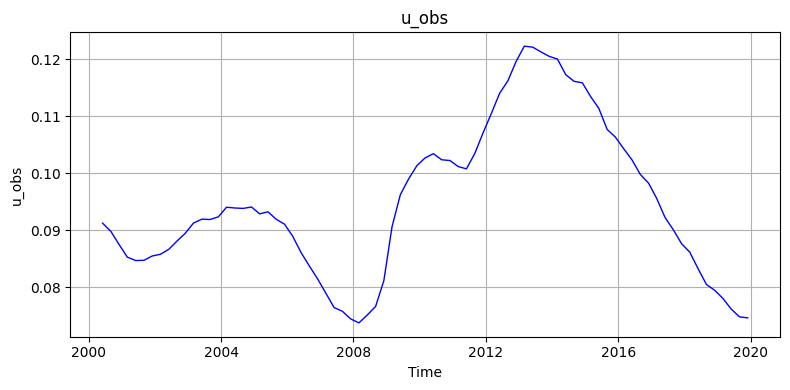

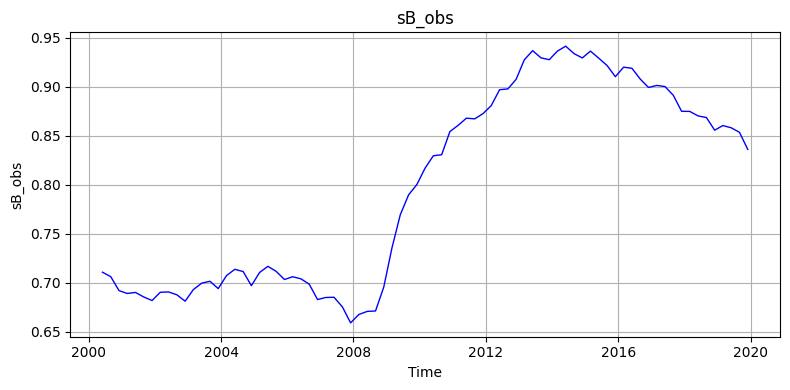

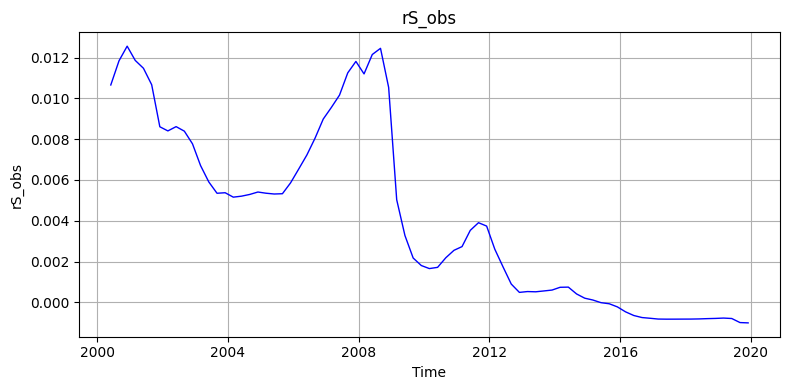

In [11]:
plot(estimation_df)

**_Treating for Seasonal Paterns_.**

Visual inspection confirms what was noted at the outset, the debt-to-GDP series exhibits seasonal patterns. Using it in this form could introduce bias in the estimation. To address this, the series is seasonally adjusted using the Classical Additive Seasonal Decomposition method.

The decomposition follows the standard representation:
$$
Y_t = T_t + S_t + I_t
$$
Where:
- $ Y_t $ is the observed series (**sB_obs**),
- $ T_t $ is the trend component,
- $ S_t $ is the seasonal component,
- $ I_t $ is the irregular (residual) component.

The seasonal component $ S_t $ is estimated using moving averages, and then removed to obtain the seasonally adjusted series:
$$
Y_t^{sa} = Y_t - S_t
$$
The decomposition is performed with a period of 4, corresponding to the quarterly frequency of the data. The adjusted series $ Y_t^{sa} $ is subsequently used for estimation purposes to ensure that the results reflect structural economic dynamics, not mechanical seasonal patterns.

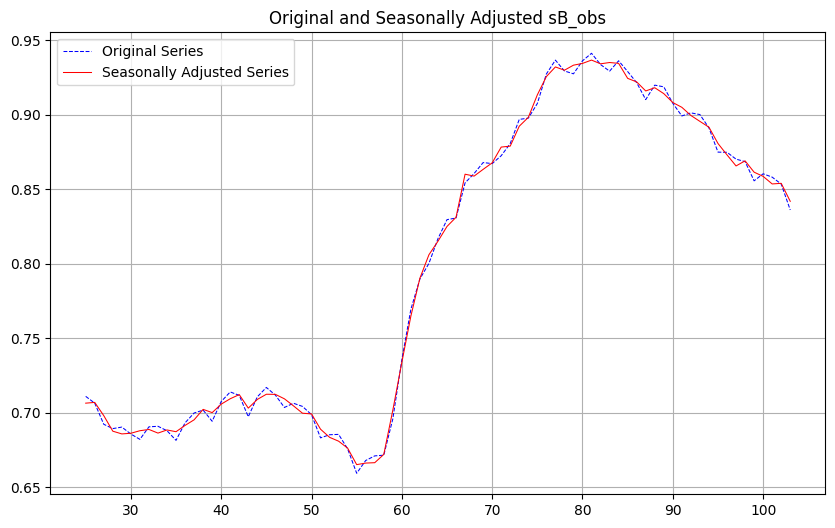

In [12]:
estimation_df = seasonally_adjustment(estimation_df, 'sB_obs', period=4)

**_Saving the Results_.**

The function **_save_df()_** saves the final dataset as a CSV file. Note that the directory path must correspond to your local machine or file system.

In [13]:
save_df(
    df=estimation_df,
    directory="/Users/eliotsatta/Documents/Master Thesis",
    filename="estimation_df.csv"
)

Saved CSV to: /Users/eliotsatta/Documents/Master Thesis/estimation_df.csv


'/Users/eliotsatta/Documents/Master Thesis/estimation_df.csv'